# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

**TODO**
- provare loss del prof
- provare con solo MAP in input
- pca?
- tutte le duration

# 0. Importing libraries

In [1]:
colab = False

In [2]:
%%capture
if colab:
  !pip install fitter
  !pip install pydot
  !pip install graphviz

In [2]:
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics


from fitter import Fitter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler

from scipy import stats

if colab:
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

C:\Users\chiar\AppData\Local\Temp\ipykernel_3348\2467376848.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 1. Load and inspect the dataset

## 1.1. Load data

In [69]:
if colab:
    data_folder = Path.cwd() / "drive" / "MyDrive" / "A3I" / "data"
    dataset_path = data_folder.joinpath("AMS_descritt_noSM_meltD_adim.csv")
    dataset_indexes_test = data_folder.joinpath("gumMap_statbench_Gumfit_NEW.csv")
else:
    dataset_path = "data/AMS_descritt_noSM_meltD_adim.csv"
    dataset_indexes_test = "data/gumMap_statbench_Gumfit_NEW.csv"

df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)

df_indexes_test = pd.read_csv(dataset_indexes_test, sep=',', encoding='utf-8') #dataset used to extract the ids for test

print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [81]:
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [82]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


## 1.2. Preprocess and split the dataset

In [83]:
# create a dictionary of dataframes, one for each duration
dfs = {}
for duration in DURATION:
    dfs[f'{duration}'] = df[df['duration[h]'] == duration].drop("duration[h]", axis=1, inplace=False)
    dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [84]:
def scale_AMS(df, k = 1.2, IdD = False):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
        IdD: To specify how standardize. Defaults to False.
    """
    if IdD:
        df['AMS'] = df.apply(lambda row: row['AMS'] * row['IdD'], axis=1)

    min_AMS = df['AMS'].min() - 1e-3 # to avoid zero values
    max_AMS = df['AMS'].max() * k

    df['AMS'] = df.apply(lambda row: (row['AMS'] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df

In [85]:
def standardize(dfs):
    
    features_not_to_scale = ['ID', 'AMS', 'mean_IdD']
    features_to_scale = dfs['1'].columns.drop(features_not_to_scale)

    order_columns = ['ID', 'AMS', 'mean_IdD'] + list(features_to_scale)

    scaler = MinMaxScaler() #min max scaler to have values in range [0, 1]
    std_dfs = {}

    for duration in DURATION:
        scaled_data = scaler.fit_transform(dfs[f'{duration}'][features_to_scale])
        non_scaled_data = dfs[f'{duration}'][features_not_to_scale]
        std_dfs[f'{duration}'] = np.concatenate([non_scaled_data, scaled_data], axis=1)

        # convert to dataframe
        std_dfs[f'{duration}'] = pd.DataFrame(std_dfs[f'{duration}'], columns=order_columns)

        # scale AMS
        std_dfs[f'{duration}'] = scale_AMS(std_dfs[f'{duration}'])

    return std_dfs

### Split the dataset into train, validation and test

In [86]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]

test_dfs = {}
for duration in DURATION:
    test_dfs[f'{duration}'] = dfs[f'{duration}'][dfs[f'{duration}']['ID'].isin(test_ID)]
    test_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [88]:
# Drop the test set from std_dfs and then create the train sets and validation sets
for duration in DURATION:
    dfs[f'{duration}'] = dfs[f'{duration}'].drop(dfs[f'{duration}'][dfs[f'{duration}']['ID'].isin(test_ID)].index)
    dfs[f'{duration}'].reset_index(drop=True, inplace=True)

validation_split = 0.1

train_dfs = {}
val_dfs = {}
for duration in DURATION:
    train_dfs[f'{duration}'], val_dfs[f'{duration}'] = train_test_split(dfs[f'{duration}'], test_size=validation_split, shuffle=False)
    train_dfs[f'{duration}'].reset_index(drop=True, inplace=True)
    val_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [89]:
train_dfs['3'].head()

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1.106796,51.500000
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,0.893204,51.500000
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1.184466,51.500000
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,0.815534,51.500000
4,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,245.328628,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,0.876011,53.195652


### Standardize datasets

In [90]:
train_dfs_std = standardize(train_dfs)
val_dfs_std = standardize(val_dfs)
test_dfs_std = standardize(test_dfs)

In [91]:
# column id must be integer
for duration in DURATION:
    train_dfs_std[f'{duration}']['ID'] = train_dfs_std[f'{duration}']['ID'].astype(int)
    val_dfs_std[f'{duration}']['ID'] = val_dfs_std[f'{duration}']['ID'].astype(int)
    test_dfs_std[f'{duration}']['ID'] = test_dfs_std[f'{duration}']['ID'].astype(int)

In [92]:
train_dfs_std['3'].head()

,ID,AMS,mean_IdD,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,0.186032,51.500000,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
1,5001,0.149663,51.500000,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
2,5001,0.199258,51.500000,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
3,5001,0.136437,51.500000,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
4,5002,0.146735,53.195652,0.161975,0.139420,0.194636,0.201272,0.713161,0.775561,0.462353,...,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658


### Add the guesses to datasets

In [93]:
def add_alpha_beta(df):

    # create two empy columns for alpha and beta
    df['alpha'] = np.nan
    df['beta'] = np.nan

    for id in df['ID'].unique():
        try:
            a, b, _, _ = stats.beta.fit(df[df['ID'] == id]['AMS'], floc=0, fscale=1)
        except:
            a, b = 1, 1
        
        df.loc[df['ID'] == id, 'alpha'] = a
        df.loc[df['ID'] == id, 'beta'] = b

    # if there are nan values, raise exception
    if df.isnull().values.any():
        raise Exception('There are nan values in the dataframe')

    return df

In [ ]:
for duration in DURATION:
    train_dfs_std[f'{duration}'] = add_alpha_beta(train_dfs_std[f'{duration}'])
    val_dfs_std[f'{duration}'] = add_alpha_beta(val_dfs_std[f'{duration}'])
    test_dfs_std[f'{duration}'] = add_alpha_beta(test_dfs_std[f'{duration}'])

In [97]:
train_dfs_std['1']

,ID,AMS,mean_IdD,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
0,5001,0.209672,28.250000,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,15.996558,77.574629
1,5001,0.132265,28.250000,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,15.996558,77.574629
2,5002,0.209284,33.469565,0.161975,0.139420,0.194636,0.201272,0.713161,0.775561,0.462353,...,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658,5.432057,26.239425
3,5002,0.167469,33.469565,0.161975,0.139420,0.194636,0.201272,0.713161,0.775561,0.462353,...,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658,5.432057,26.239425
4,5002,0.197785,33.469565,0.161975,0.139420,0.194636,0.201272,0.713161,0.775561,0.462353,...,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658,5.432057,26.239425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46660,20034,0.123402,12.635714,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,0.954521,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,3.732804,17.650384
46661,20034,0.195395,12.635714,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,0.954521,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,3.732804,17.650384
46662,20034,0.198164,12.635714,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,0.954521,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,3.732804,17.650384
46663,20034,0.128940,12.635714,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,0.954521,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,3.732804,17.650384


## 1.3. Dataset inspection

#### Timeseries length distribution for each duration, both for training and validation

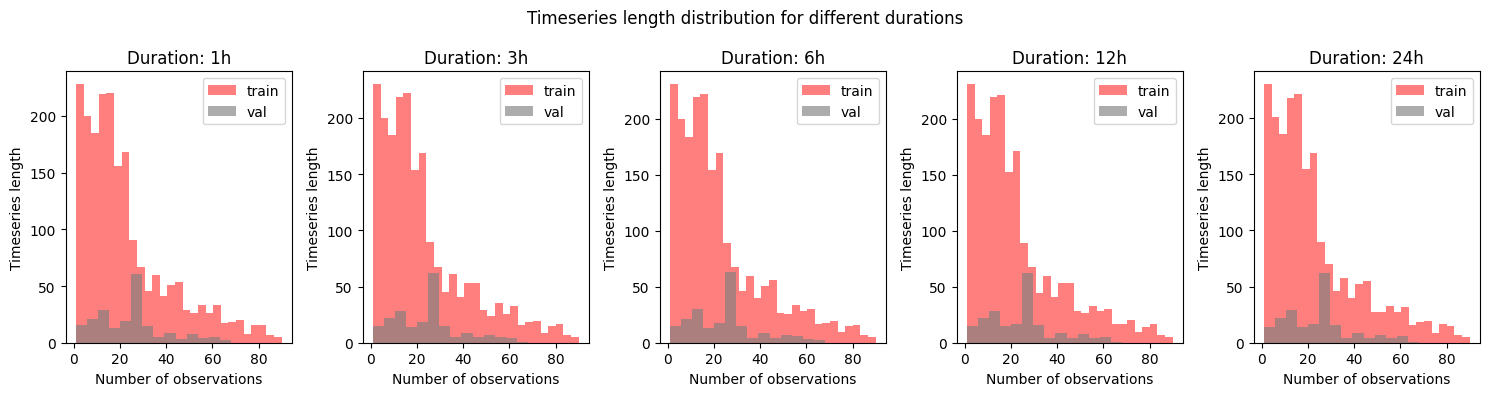

In [98]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns
fig.suptitle("Timeseries length distribution for different durations")

for i, duration in enumerate(DURATION):
    ax = axes[i]
    ax.hist(train_dfs_std[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.5, label='train', color='red')
    ax.hist(val_dfs_std[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.65, label='val', color='gray')
    ax.legend()
    ax.set_title(f"Duration: {duration}h")
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("Timeseries length")

plt.tight_layout()
plt.show()

### MAP distribution for training and validation

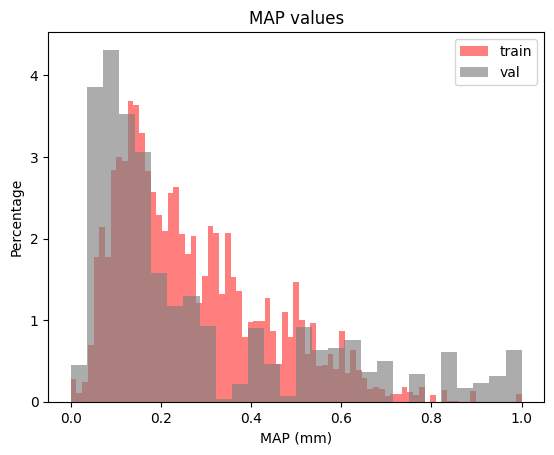

In [99]:
plt.hist(train_dfs_std['3']['MAP(mm)'], bins='auto', alpha=0.5, label='train', density=True, color='red')
plt.hist(val_dfs_std['3']['MAP(mm)'], bins='auto', alpha=0.65, label='val', density=True, color='gray')
plt.ylabel('Percentage')
plt.title('MAP values')
plt.xlabel('MAP (mm)')
plt.legend()
plt.show()

## 1.4. Prepare data for training

In [100]:
train_dfs_std['1'].columns

Index(['ID', 'AMS', 'mean_IdD', 'HMerit_mean(m)', 'HMerit_stdev(m)',
       'Slope_mean(deg)', 'Slope_stdev(deg)', 'Aspect_mean(deg)',
       'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)',
       'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)',
       'OrograTirr_mean(m)', 'OrograTirr_stdev(m)', 'OrograTirr_max(m)',
       'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y',
       'alpha', 'beta'],
      dtype='object')

In [102]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_dfs_std['1'].columns
input_columns = columns[3:-2]
output_column = 'AMS'
parameters_columns = ['alpha', 'beta']
print('Input columns: ', input_columns)

Input columns:  Index(['HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [103]:
inputs_train = {}
outputs_train = {}
parameters_train = {}
for duration in DURATION:
    inputs_train[f'{duration}'] = train_dfs_std[f'{duration}'][input_columns]
    outputs_train[f'{duration}'] = train_dfs_std[f'{duration}'][output_column]
    parameters_train[f'{duration}'] = train_dfs_std[f'{duration}'][parameters_columns]

inputs_val = {}
outputs_val = {}
parameters_val = {}
for duration in DURATION:
    inputs_val[f'{duration}'] = val_dfs_std[f'{duration}'][input_columns]
    outputs_val[f'{duration}'] = val_dfs_std[f'{duration}'][output_column]
    parameters_val[f'{duration}'] = val_dfs_std[f'{duration}'][parameters_columns]

inputs_test = {}
outputs_test = {}
parameters_test = {}
for duration in DURATION:
    inputs_test[f'{duration}'] = test_dfs_std[f'{duration}'][input_columns]
    outputs_test[f'{duration}'] = test_dfs_std[f'{duration}'][output_column]
    parameters_test[f'{duration}'] = test_dfs_std[f'{duration}'][parameters_columns]

In [105]:
inputs_train['3'].head()

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,0.342076,0.437630,0.507912,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
1,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,0.342076,0.437630,0.507912,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
2,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,0.342076,0.437630,0.507912,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
3,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,0.342076,0.437630,0.507912,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
4,0.161975,0.139420,0.194636,0.201272,0.713161,0.775561,0.462353,0.272740,0.394987,0.403354,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658


In [106]:
# Get the initial guesses for the parameters of the distribution
def get_initial_guesses(train_dfs, duration, distribution, plot = False):
    ams = train_dfs[duration]['AMS']
    
    if distribution == 'beta':
        a_guess, b_guess, _, _ = stats.beta.fit(ams, floc=0, fscale=1)
        if plot:
            plt.hist(ams, bins=100, density=True, alpha=0.6, color='g', label=f'AMS for duration {duration} - Train')
            x = np.linspace(0, 1, 100)
            plt.plot(x, stats.beta.pdf(x, a_guess, b_guess), 'r-', lw=5, alpha=0.6, label='beta pdf')
            plt.legend()
            plt.show()        
        return a_guess, b_guess
    
    return None, None

# 2. Model definition

#### Bias model

In [107]:
def build_nn_beta_model_bias(input_shape, hidden, alpha_guess=1, beta_guess=1):
    alpha_guess = np.log(alpha_guess)
    beta_guess = np.log(beta_guess)

    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)

    bias_initializer = tf.keras.initializers.Constant([alpha_guess, beta_guess])
    alpha_beta = layers.Dense(2, activation='exponential', bias_initializer=bias_initializer)(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=t[:,1], concentration1=t[:,0], validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

#### Base model

In [108]:
def build_nn_beta_model(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)
    alpha_beta = layers.Dense(2, activation='exponential')(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=t[:,0:1], concentration1=t[:,1:2], validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

# 3. Metrics 

In [109]:
def get_scores(dist, y, label, color, plot = True):
    num_samples = 1
    y_pred = dist.sample(num_samples).numpy().ravel()
    
    r2 = metrics.r2_score(y, y_pred)
    mae = metrics.mean_absolute_error(y, y_pred)
    ks_statistics, _ = stats.ks_2samp(y, y_pred)

    if plot:
        plt.hist(y, bins='auto', alpha=0.7, label=label, density=True, color='green');
        #sns.kdeplot(y_pred, label='Estimated sample', fill=True)
        plt.hist(y_pred, bins='auto', alpha=0.5, label='Predicted', density=True, color=color);
        plt.legend()
        plt.show()

    return r2, mae, ks_statistics

def plot_series(data, labels=None, predictions=None, figsize=None, filled_version=None, std=None, ci=None, title=None, ylim=None):
    
    plt.figure(figsize=figsize)
    plt.plot(data.index, data.values, zorder=0)
    
    if filled_version is not None:
        filled = filled_version.copy()
        filled[~data['value'].isnull()] = np.nan
        plt.scatter(filled.index, filled, marker='.', c='tab:orange', s=5);
    
    # Plot standard deviations
    if std is not None:
        lb = data.values.ravel() - std.values.ravel()
        ub = data.values.ravel() + std.values.ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='+/- std')
    
    # Plot confidence intervals
    if ci is not None:
        lb = ci[0].ravel()
        ub = ci[1].ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='C.I.')
    
    # Rotated x ticks
    plt.xticks(rotation=45)
    
    # Plot labels
    if labels is not None:
        plt.scatter(labels.values, data.loc[labels], color='red', zorder=2, s=5)
    
    # Predictions
    if predictions is not None:
        plt.scatter(predictions.values, data.loc[predictions], color='black', alpha=.4, zorder=3, s=5)
    
    # Force y limits
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.grid(linestyle=':')
    plt.title(title)
    plt.tight_layout()

def percentage_in_ci(inputs, y, dist, confidence, distribution = 'beta', start = None, end = None, plot = True, num_samples=1):
    
    if start is None:
        start = 0
    if end is None:
        end = len(y)

    if distribution == 'beta':
        lb, ub = stats.beta.interval(confidence, a=dist.concentration1, b=dist.concentration0)
        mean_dist = dist.mean().numpy().ravel()
        y_pred = dist.sample(num_samples).numpy().ravel()

        if plot:
            plot_series(pd.Series(index=inputs[start:end].index, data=mean_dist[start:end]), ci=(lb[start:end], ub[start:end]), figsize=(12,6))
            plt.scatter(inputs[start:end].index, y_pred[start:end], marker='o', color='blue', label='Predicted');
            plt.scatter(inputs[start:end].index, y[start:end], marker='x', color='red', label='True');
            plt.legend()
            plt.show()
    
        count_true = 0
        for i in range(len(y)):
            if lb[i] <= y[i] <= ub[i]:
                count_true += 1
        
        true_guess = count_true/len(y)*100

        return true_guess

# 4. Training

In [110]:
def train_nn_model(model, X, y, batch_size, loss, lr, verbose=0, patience=10, validation_data=None, **fit_params):
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)
    
    # Build the early stop callback
    cb = []
    if validation_split is not None:
        cb += [callbacks.EarlyStopping(patience=patience, restore_best_weights=True)]
    
    # Train the model
    history = model.fit(X, y, batch_size=batch_size, callbacks=cb, validation_data=validation_data, verbose=verbose, **fit_params)
    
    return history

def plot_training_history(history=None, figsize=None, print_final_scores=True):
    plt.figure(figsize=figsize)
    for metric in history.history.keys():
        plt.plot(history.history[metric], label=metric)
    
    if len(history.history.keys()) > 0:
        plt.legend()
    plt.xlabel('epochs')
    plt.grid(linestyle=':')
    plt.tight_layout()
    plt.show()
    
    if print_final_scores:
        trl = history.history["loss"][-1]
        s = f'Final loss: {trl:.4f} (training)'
        if 'val_loss' in history.history:
            vll = history.history["val_loss"][-1]
            s += f', {vll:.4f} (validation)'
        print(s)

# Duration 3 - LOSS PROF

## Training

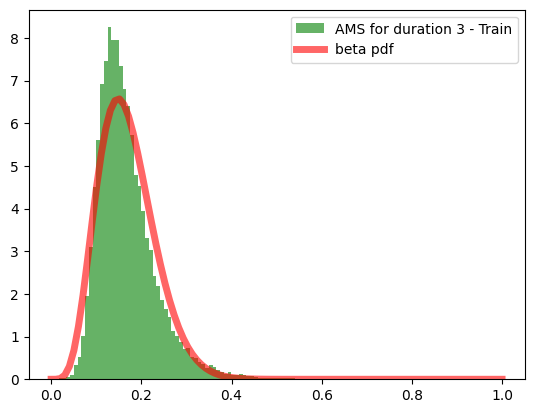

5.992658120317382 29.58647050836343


In [111]:
duration = '3'

X_train = inputs_train[duration].values
y_train  = outputs_train[duration].values
X_val = inputs_val[duration].values
y_val = outputs_val[duration].values
X_test = inputs_test[duration].values
y_test = outputs_test[duration].values

a_guess, b_guess = get_initial_guesses(train_dfs_std, duration, 'beta', plot=True)
print(a_guess, b_guess)

In [163]:
# Parameters for the training
batch_size = 16
epochs = 20
lr = 1e-3
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

print('Training the model without the guesses...')
model_no_guess = build_nn_beta_model(input_shape=(X_train.shape[1],), hidden=[64, 32])
history = train_nn_model(model_no_guess, X_train, y_train, batch_size, loss_prof, lr, verbose=1, patience=10, validation_data=(X_val, y_val), epochs=epochs)
#plot_training_history(history, figsize=(14, 4))

print('\nTraining the model with the guesses...')
#model_guess = build_nn_beta_model_bias(input_shape=(X_train.shape[1],), hidden=[64, 32], alpha_guess=a_guess, beta_guess=b_guess)
#history = train_nn_model(model_guess, X_train, y_train, batch_size, loss_prof, lr, verbose=1, patience=10, validation_data=(X_val, y_val), epochs=epochs)
#plot_training_history(history, figsize=(14, 4))

Training the model without the guesses...
Epoch 1/20
2917/2917 [==============================] - 10s 3ms/step - loss: -1.1972 - val_loss: -1.3101
Epoch 2/20
2917/2917 [==============================] - 8s 3ms/step - loss: -1.3830 - val_loss: -1.0718
Epoch 3/20
2917/2917 [==============================] - 8s 3ms/step - loss: -1.3887 - val_loss: -1.2608
Epoch 4/20
2917/2917 [==============================] - 8s 3ms/step - loss: -1.3927 - val_loss: -1.3079
Epoch 5/20
2917/2917 [==============================] - 8s 3ms/step - loss: -1.3936 - val_loss: -1.3063
Epoch 6/20
2917/2917 [==============================] - 8s 3ms/step - loss: -1.3941 - val_loss: -1.3321
Epoch 7/20
2917/2917 [==============================] - 8s 3ms/step - loss: -1.3958 - val_loss: -1.2642
Epoch 8/20
2917/2917 [==============================] - 8s 3ms/step - loss: -1.3975 - val_loss: -1.3224
Epoch 9/20
2917/2917 [==============================] - 8s 3ms/step - loss: -1.3988 - val_loss: -1.2426
Epoch 10/20
2917/2917

Evaluating the models on training set...

No guesses:


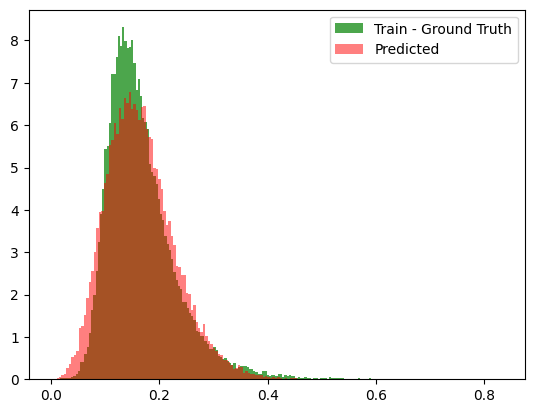

Train:
R2: -0.93
MAE: 0.07
KS statistics: 0.05
Alpha: 6.07
Beta: 30.77

With guesses:


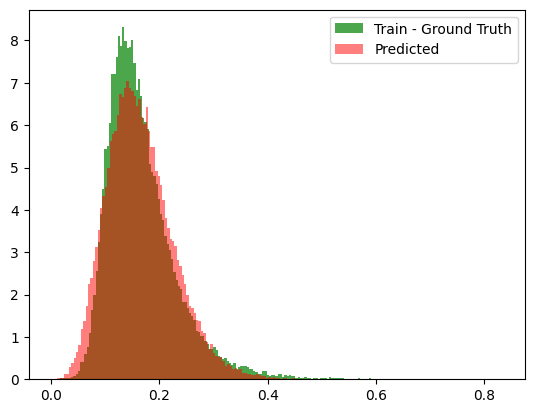

Train:
R2: -0.86
MAE: 0.07
KS statistics: 0.04
Alpha: 6.36
Beta: 32.39


In [164]:
print('Evaluating the models on training set...')

print('\nNo guesses:')
dist_train_no_guess = model_no_guess(X_train)
r2_train_no_guess, mae_train_no_guess, ks_statist_train_no_guess = get_scores(dist_train_no_guess, y_train, 'Train - Ground Truth', 'red')
a_train_no_guess = dist_train_no_guess.concentration1.numpy().mean()
b_train_no_guess = dist_train_no_guess.concentration0.numpy().mean()
print('Train:')
print(f'R2: {r2_train_no_guess:.2f}')
print(f'MAE: {mae_train_no_guess:.2f}')
print(f'KS statistics: {ks_statist_train_no_guess:.2f}')
print(f'Alpha: {a_train_no_guess:.2f}')
print(f'Beta: {b_train_no_guess:.2f}')

print('\nWith guesses:')
dist_train_guess = model_guess(X_train)
r2_train_guess, mae_train_guess, ks_statist_train_guess = get_scores(dist_train_guess, y_train, 'Train - Ground Truth', 'red')
a_train_guess = dist_train_guess.concentration1.numpy().mean()
b_train_guess = dist_train_guess.concentration0.numpy().mean()
print('Train:')
print(f'R2: {r2_train_guess:.2f}')
print(f'MAE: {mae_train_guess:.2f}')
print(f'KS statistics: {ks_statist_train_guess:.2f}')
print(f'Alpha: {a_train_guess:.2f}')
print(f'Beta: {b_train_guess:.2f}')

# Store the results in a dataframe
results = pd.DataFrame(columns=['Model', 'Split', 'R2', 'MAE', 'KS statistics', 'Alpha', 'Beta'])

train_no_guess = ['No guesses', 'Train', r2_train_no_guess, mae_train_no_guess, ks_statist_train_no_guess, a_train_no_guess, b_train_no_guess]
train_guess = ['With guesses', 'Train', r2_train_guess, mae_train_guess, ks_statist_train_guess, a_train_guess, b_train_guess]

results.loc[0] = train_no_guess
results.loc[1] = train_guess

Evaluating the models on validation set...

No guesses:


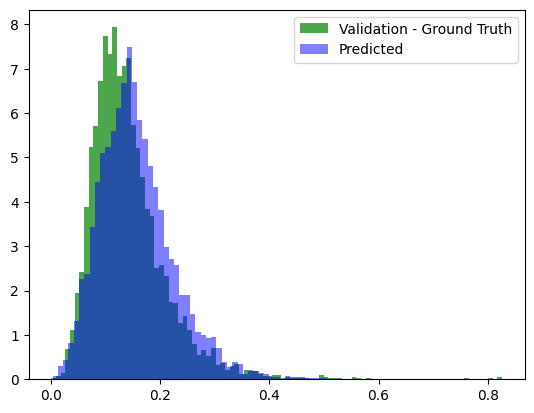

Validation:
R2: -1.01
MAE: 0.07
KS statistics: 0.14
Alpha: 5.67
Beta: 30.72

With guesses:


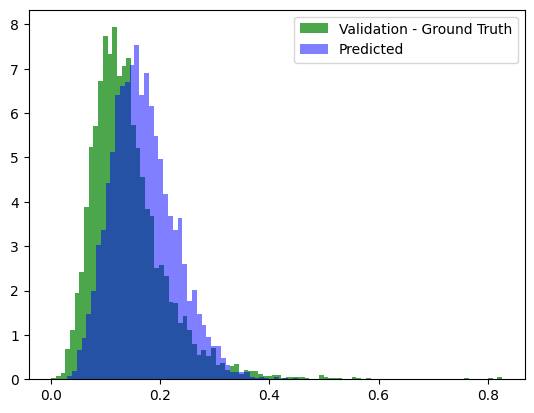

Validation:
R2: -0.85
MAE: 0.07
KS statistics: 0.25
Alpha: 7.08
Beta: 34.51


In [114]:
print('Evaluating the models on validation set...')

print('\nNo guesses:')
dist_val_no_guess = model_no_guess(X_val)
r2_val_no_guess, mae_val_no_guess, ks_statist_val_no_guess = get_scores(dist_val_no_guess, y_val, 'Validation - Ground Truth', 'blue')
a_val_no_guess = dist_val_no_guess.concentration1.numpy().mean()
b_val_no_guess = dist_val_no_guess.concentration0.numpy().mean()
print('Validation:')
print(f'R2: {r2_val_no_guess:.2f}')
print(f'MAE: {mae_val_no_guess:.2f}')
print(f'KS statistics: {ks_statist_val_no_guess:.2f}')
print(f'Alpha: {a_val_no_guess:.2f}')
print(f'Beta: {b_val_no_guess:.2f}')

print('\nWith guesses:')
dist_val_guess = model_guess(X_val)
r2_val_guess, mae_val_guess, ks_statist_val_guess = get_scores(dist_val_guess, y_val, 'Validation - Ground Truth', 'blue')
a_val_guess = dist_val_guess.concentration1.numpy().mean()
b_val_guess = dist_val_guess.concentration0.numpy().mean()
print('Validation:')
print(f'R2: {r2_val_guess:.2f}')
print(f'MAE: {mae_val_guess:.2f}')
print(f'KS statistics: {ks_statist_val_guess:.2f}')
print(f'Alpha: {a_val_guess:.2f}')
print(f'Beta: {b_val_guess:.2f}')

val_no_guess = ['No guesses', 'Validation', r2_val_no_guess, mae_val_no_guess, ks_statist_val_no_guess, a_val_no_guess, b_val_no_guess]
val_guess = ['With guesses', 'Validation', r2_val_guess, mae_val_guess, ks_statist_val_guess, a_val_guess, b_val_guess]

results.loc[2] = val_no_guess
results.loc[3] = val_guess

## Predictions on test set

Evaluating the models on test set...

No guesses:


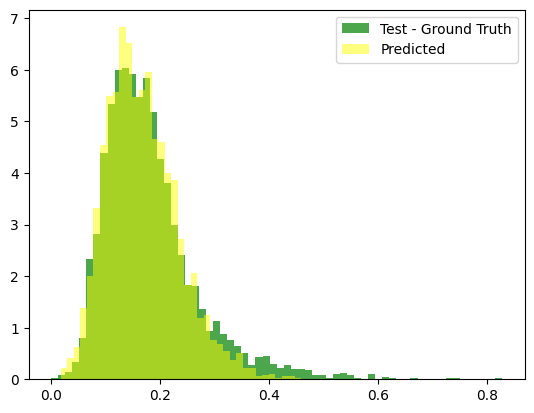

Test:
R2: -0.58
MAE: 0.08
KS statistics: 0.06
Alpha: 5.97
Beta: 29.94

With guesses:


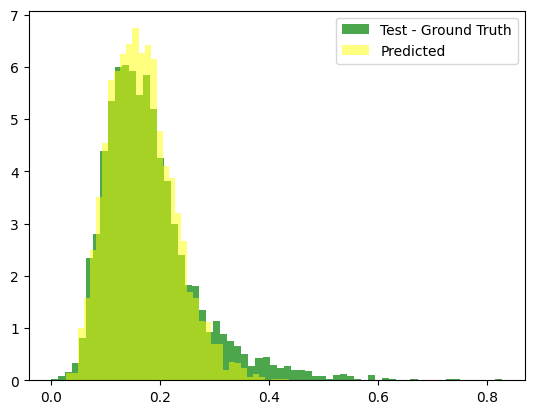

Test:
R2: -0.49
MAE: 0.08
KS statistics: 0.07
Alpha: 6.51
Beta: 32.02


In [115]:
print('Evaluating the models on test set...')

print('\nNo guesses:')
dist_test_no_guess = model_no_guess(X_test)
r2_test_no_guess, mae_test_no_guess, ks_statist_test_no_guess = get_scores(dist_test_no_guess, y_test, 'Test - Ground Truth', 'yellow')
a_test_no_guess = dist_test_no_guess.concentration1.numpy().mean()
b_test_no_guess = dist_test_no_guess.concentration0.numpy().mean()
print('Test:')
print(f'R2: {r2_test_no_guess:.2f}')
print(f'MAE: {mae_test_no_guess:.2f}')
print(f'KS statistics: {ks_statist_test_no_guess:.2f}')
print(f'Alpha: {a_test_no_guess:.2f}')
print(f'Beta: {b_test_no_guess:.2f}')

print('\nWith guesses:')
dist_test_guess = model_guess(X_test)
r2_test_guess, mae_test_guess, ks_statist_test_guess = get_scores(dist_test_guess, y_test, 'Test - Ground Truth', 'yellow')
a_test_guess = dist_test_guess.concentration1.numpy().mean()
b_test_guess = dist_test_guess.concentration0.numpy().mean()
print('Test:')
print(f'R2: {r2_test_guess:.2f}')
print(f'MAE: {mae_test_guess:.2f}')
print(f'KS statistics: {ks_statist_test_guess:.2f}')
print(f'Alpha: {a_test_guess:.2f}')
print(f'Beta: {b_test_guess:.2f}')

test_no_guess = ['No guesses', 'Test', r2_test_no_guess, mae_test_no_guess, ks_statist_test_no_guess, a_test_no_guess, b_test_no_guess]
test_guess = ['With guesses', 'Test', r2_test_guess, mae_test_guess, ks_statist_test_guess, a_test_guess, b_test_guess]

results.loc[4] = test_no_guess
results.loc[5] = test_guess

Evaluation based on confidence intervals..

No guesses:


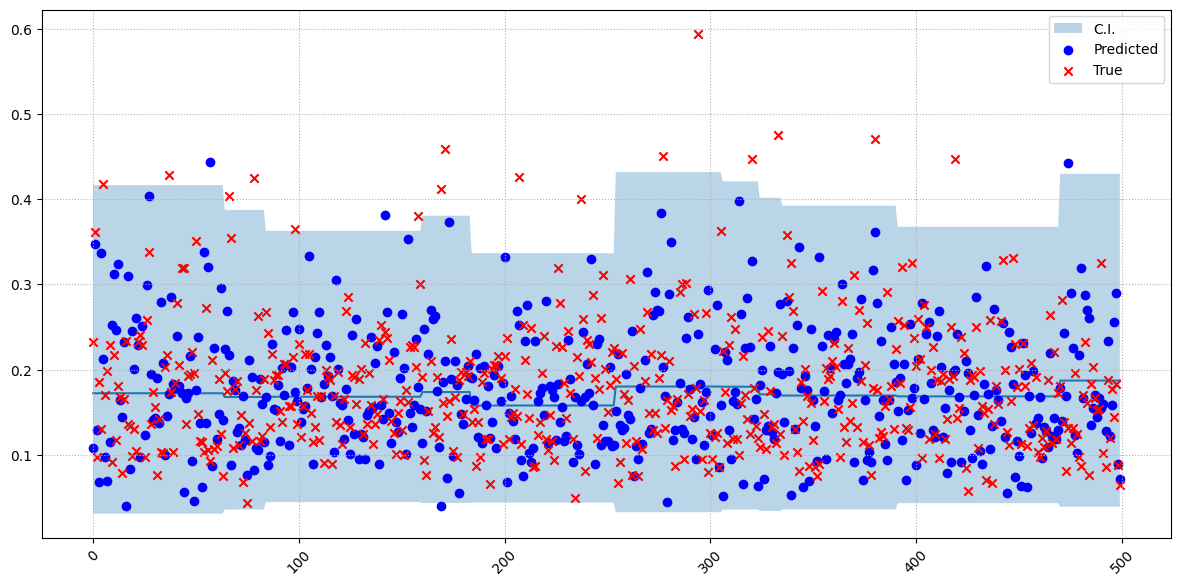


With guesses:


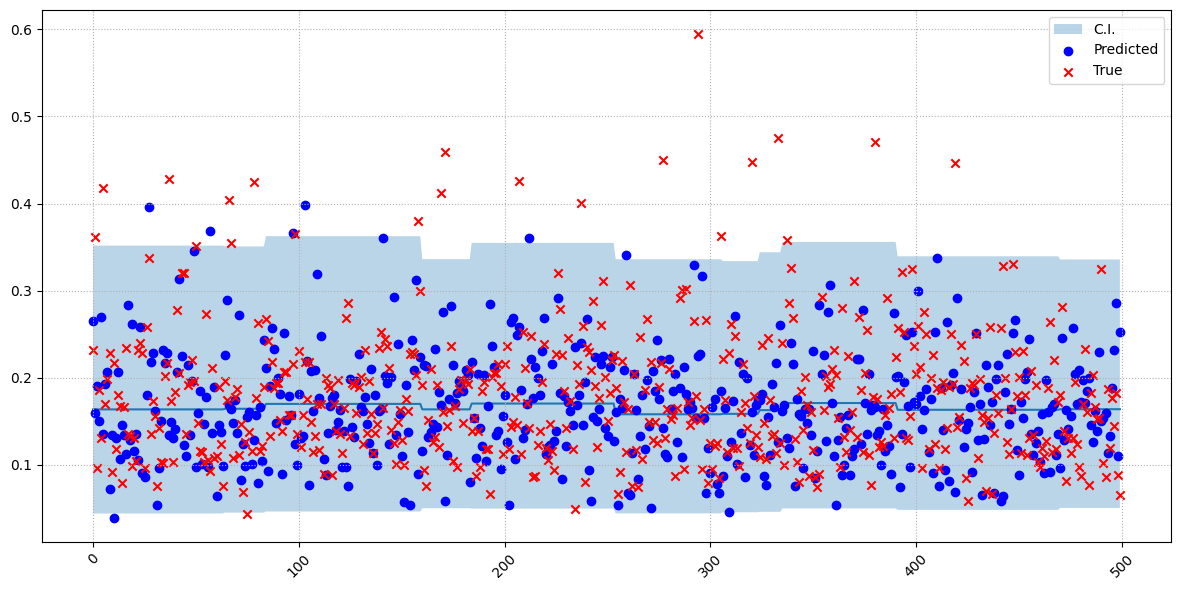

In [116]:
confidence = 0.99

print('Evaluation based on confidence intervals..')
ci_scores = pd.DataFrame(columns=['Model', 'True values inside the C.I.'])

print('\nNo guesses:')
inside_no_guess = percentage_in_ci(inputs_test[duration], y_test, dist_test_no_guess, confidence, end = 500)

print('\nWith guesses:')
inside_guess = percentage_in_ci(inputs_test[duration], y_test, dist_test_guess, confidence, end = 500)

# Save the results
ci_score_no_guess = ['No guesses', inside_no_guess]
ci_score_guess = ['With guesses', inside_guess]

ci_scores.loc[0] = ci_score_no_guess
ci_scores.loc[1] = ci_score_guess

#### Compare results obtained with and without guesses

In [117]:
display(results)

display(ci_scores)

,Model,Split,R2,MAE,KS statistics,Alpha,Beta
0,No guesses,Train,-1.011345,0.071367,0.060373,6.015063,29.529146
1,With guesses,Train,-0.857674,0.068777,0.057072,6.380002,31.554197
2,No guesses,Validation,-1.007293,0.073873,0.137319,5.666300,30.720100
3,With guesses,Validation,-0.850277,0.072905,0.246673,7.079134,34.512875
4,No guesses,Test,-0.584029,0.081807,0.056763,5.972196,29.940212
5,With guesses,Test,-0.493794,0.078942,0.074603,6.508154,32.017384


,Model,True values inside the C.I.
0,No guesses,94.680506
1,With guesses,94.421018


## Parameters

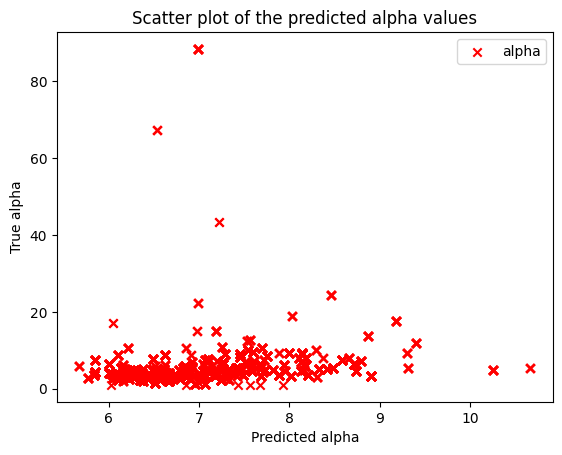

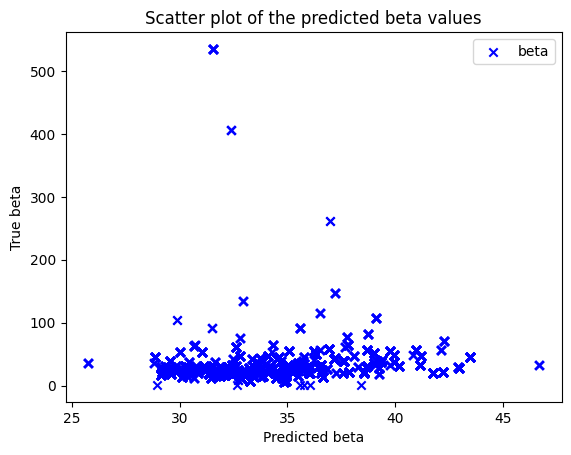

In [165]:
a_pred = dist_val_guess.concentration1.numpy()
b_pred = dist_val_guess.concentration0.numpy()

# scatter plot of the predicted alpha values
plt.scatter(a_pred, parameters_val[duration]['alpha'], color='red', label='alpha', marker='x')
plt.xlabel('Predicted alpha')
plt.ylabel('True alpha')
plt.legend()
plt.title('Scatter plot of the predicted alpha values')
plt.show()

# scatter plot of the predicted beta values
plt.scatter(b_pred, parameters_val[duration]['beta'], color='blue', label='beta', marker='x')
plt.xlabel('Predicted beta')
plt.ylabel('True beta')
plt.legend()
plt.title('Scatter plot of the predicted beta values')
plt.show()

True alpha:  2.524154364398666 Predicted alpha:  3.7894068
True beta:  12.700187100754373 Predicted beta:  21.588968


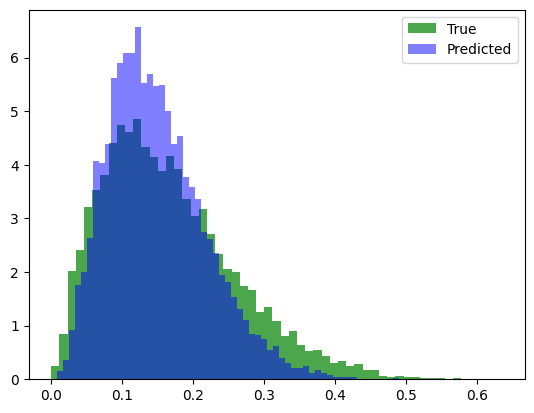

-0.5820719126899481


In [205]:
index = 50

a_pred_0 = dist_train_no_guess.concentration1.numpy().ravel()[index]
b_pred_0 = dist_train_no_guess.concentration0.numpy().ravel()[index]

a_true_0 = parameters_train[duration]['alpha'][index]
b_true_0 = parameters_train[duration]['beta'][index]

print('True alpha: ', a_true_0, 'Predicted alpha: ', a_pred_0)
print('True beta: ', b_true_0, 'Predicted beta: ', b_pred_0)

samples_pred = stats.beta.rvs(a=a_pred_0, b=b_pred_0, size=10000)
samples_true = stats.beta.rvs(a=a_true_0, b=b_true_0, size=10000)

plt.hist(samples_true, bins='auto', alpha=0.7, label='True', density=True, color='green');
plt.hist(samples_pred, bins='auto', alpha=0.5, label='Predicted', density=True, color='blue');
plt.legend()
plt.show()

print(metrics.r2_score(samples_true, samples_pred))

In [199]:
# calculate the biasr for the alpha parameter

a_true = parameters_test[duration]['alpha'].to_numpy()
a_pred = dist_test_no_guess.concentration1.numpy()

# calculate the biasr
biasr = ((a_true - a_pred) / a_true).mean()
print(f'Biasr for the alpha parameter: {biasr:.2f}')

#rmse
rmse = metrics.root_mean_squared_error(a_true, a_pred)
print(f'RMSE for the alpha parameter: {rmse:.2f}')

Biasr for the alpha parameter: -0.49
RMSE for the alpha parameter: 2.74


In [197]:
# calculate the biasr for the alpha parameter

b_true = parameters_test[duration]['beta'].to_numpy()
b_pred = dist_test_no_guess.concentration0.numpy()

# calculate the biasr
biasr = ((b_true - b_pred) / b_true).mean()
print(f'Biasr for the alpha parameter: {biasr:.2f}')

#rmse
rmse = metrics.root_mean_squared_error(b_true, b_pred)
print(f'RMSE for the alpha parameter: {rmse:.2f}')

Biasr for the alpha parameter: -0.69
RMSE for the alpha parameter: 14.88
